In [1]:
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import pathlib
import PIL 
import numpy as np
import os
import plotly.graph_objects as go
import seaborn as sns
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from random import sample

import warnings

warnings.filterwarnings('ignore')

In [2]:
data_dir = image_dataset_from_directory(
    '../cacao_photos/',
    label_mode='int')


Found 2829 files belonging to 3 classes.


In [3]:
class_names = data_dir.class_names

def count_data_per_class() -> None:
    for class_name in class_names:
        print(class_name, ":", len(os.listdir("../cacao_photos/"+class_name)))

def get_class_count(class_name:str) -> int:

    if class_name in class_names:
        return len(os.listdir("../cacao_photos/"+class_name))
    else:
        return 0

count_data_per_class()
get_class_count('black_pod_rot')

black_pod_rot : 943
healthy : 943
pod_borer : 943


943

In [4]:
count_data_per_class()

black_pod_rot : 943
healthy : 943
pod_borer : 943


In [5]:

batch_size = 10
img_height = 224
img_width = 224
epochs = 30

In [6]:
train_dataset = image_dataset_from_directory(
    '../cacao_photos/',
    validation_split = 0.2,
    labels='inferred',
    subset = 'training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size= batch_size
)

Found 2829 files belonging to 3 classes.
Using 2264 files for training.


In [7]:
validation_dataset = image_dataset_from_directory(
    '../cacao_photos/',
    validation_split = 0.2,
    labels='inferred',
    subset = 'validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size= batch_size
)

Found 2829 files belonging to 3 classes.
Using 565 files for validation.


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
normalization_layer = layers.Rescaling(1./255)

In [10]:
normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [11]:
from tensorflow.keras.applications import ResNet50

In [12]:
num_classes = len(class_names)

pretrained_model = ResNet50(include_top=False, input_shape=(img_height, img_width, 3))
pretrained_model.trainable = False
for layer in pretrained_model.layers:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

model = Sequential([
    pretrained_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation="softmax")
])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  mode='min',
                                                  patience=4)

model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
Total params: 23,593,859
Trainable params: 6,147
Non-trainable params: 23,587,712
_________________________________________________________________


In [13]:
from tensorflow.keras.callbacks import TensorBoard

file_name = 'results_ResNet50_RMSprop'

tensorboard = TensorBoard(log_dir="../logs\\{}".format(file_name))

In [14]:
model_history = model.fit(train_dataset,
                                  epochs=epochs,
                                  callbacks = [early_stopping, tensorboard],
                                  validation_data=validation_dataset)

Epoch 1/30
227/227 [==============================] - 118s 473ms/step - loss: 0.7224 - accuracy: 0.7107 - val_loss: 0.4532 - val_accuracy: 0.8088
Epoch 2/30
227/227 [==============================] - 76s 333ms/step - loss: 0.4721 - accuracy: 0.8176 - val_loss: 0.4836 - val_accuracy: 0.8159
Epoch 3/30
227/227 [==============================] - 68s 298ms/step - loss: 0.3987 - accuracy: 0.8432 - val_loss: 0.6224 - val_accuracy: 0.7628
Epoch 4/30
227/227 [==============================] - 64s 281ms/step - loss: 0.3578 - accuracy: 0.8591 - val_loss: 0.4078 - val_accuracy: 0.8407
Epoch 5/30
227/227 [==============================] - 92s 407ms/step - loss: 0.3344 - accuracy: 0.8675 - val_loss: 0.3983 - val_accuracy: 0.8389
Epoch 6/30
227/227 [==============================] - 73s 322ms/step - loss: 0.3067 - accuracy: 0.8785 - val_loss: 0.3652 - val_accuracy: 0.8513
Epoch 7/30
227/227 [==============================] - 64s 280ms/step - loss: 0.2916 - accuracy: 0.8940 - val_loss: 0.3676 - val_a

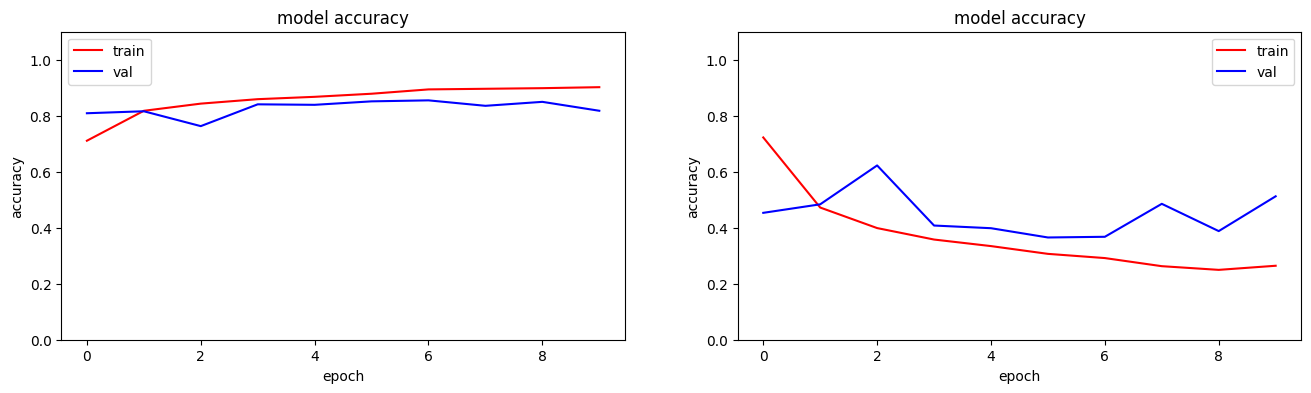

In [15]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(model_history.history['accuracy'], color="red")
plt.plot(model_history.history['val_accuracy'], color="blue")
plt.title('model accuracy')
plt.ylim(top=1.1)
plt.ylim(bottom=0)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(model_history.history['loss'], color="red")
plt.plot(model_history.history['val_loss'], color="blue")
plt.title('model accuracy')
plt.ylim(top=1.1)
plt.ylim(bottom=0)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.show()

In [16]:

def display_training_curves(training, validation, yaxis):
    if yaxis == "loss":
        ylabel = "Loss"
        title = "Loss with respect to Epochs"
    else:
        ylabel = "Accuracy"
        title = "Accuracy with respect to Epochs"
        
    fig = go.Figure()
        
    fig.add_trace(
        go.Scatter(x=np.arange(1, epochs+1), mode='lines+markers', y=training, marker=dict(color="dodgerblue"),
               name="Training"))
    
    fig.add_trace(
        go.Scatter(x=np.arange(1, epochs+1), mode='lines+markers', y=validation, marker=dict(color="darkorange"),
               name="Validation"))
    
    fig.update_layout(title_text=title, yaxis_title=ylabel, xaxis_title="Epochs", template="plotly_white")
    fig.show()



In [17]:
display_training_curves(
    model_history.history['accuracy'], 
    model_history.history['val_accuracy'], 
    'accuracy')

In [18]:
display_training_curves(
    model_history.history['loss'], 
    model_history.history['val_loss'], 
    'validation')

In [19]:
val_pred = model.predict(validation_dataset)

57/57 [==============================] - 18s 193ms/step


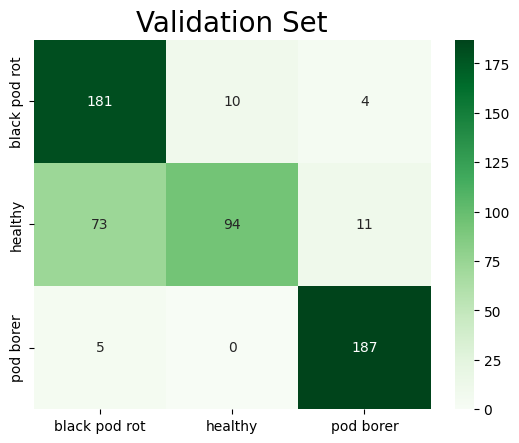

In [20]:


labels = []
preds = []
for _, label in validation_dataset.as_numpy_iterator():
    for i in label:
        labels.append(i)

for pred in val_pred:
    pred_list = pred.tolist()
    preds.append(pred_list.index(max(pred_list)))

val_cm = confusion_matrix(labels, preds, labels=[0,1,2],)
val_axis_labels = ['black pod rot', 'healthy', 'pod borer']
plt.title("Validation Set", fontsize =20)
val_ax = sns.heatmap(val_cm,
                 cmap="Greens",
                 annot=True,
                 xticklabels=val_axis_labels,
                 yticklabels=val_axis_labels,
                 fmt="d")

In [21]:
print(classification_report(labels, preds, labels=[0, 1, 2]))

              precision    recall  f1-score   support

           0       0.70      0.93      0.80       195
           1       0.90      0.53      0.67       178
           2       0.93      0.97      0.95       192

    accuracy                           0.82       565
   macro avg       0.84      0.81      0.80       565
weighted avg       0.84      0.82      0.81       565

